<a href="https://colab.research.google.com/github/philwebsurfer/dlfinal/blob/main/paper06_model_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best Model

_Jorge III Altamirano-Astorga, Ita-Andehui Santiago, Luz Aurora Hernández._

_Prof.: Edgar Francisco Román-Rangel._

In [1]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
  SimpleRNN, Input, Conv1D, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf.get_logger().setLevel('ERROR')

BATCH_SIZE=256

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    ;
    
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Performance Plots for Model."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

#render_mpl_table(df.head().applymap(shorten), col_width=5)
#sinaica = pd.read_pickle(uploaded)
#airdata = pd.read_pickle(os.path.join(base_url, "data/air-imputated.pickle.gz"))
data =  pd.read_pickle(os.path.join(base_url, "data/data_5min.pickle.gz"))
data = data[~data.isna().any(axis=1)]
data.head(2)

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,year,month,day,hour,minute,second,NO,CO,NO2,NOx,O3,PM10,PM2.5,SO2,temperature_outdoor,feels_like,pressure_outdoor,humidity_outdoor,wind_speed,wind_deg
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-12 06:00:00,21.530000,777.410000,43.974000,151849.400000,37.200000,1.0,2021.0,2.0,12.0,6.0,4.000000,15.000000,0.205071,2.200547,0.031007,0.206996,0.002,45.021898,22.005474,0.004002,14.928066,13.597920,1020.998175,43.001825,2.565310,109.799270
2021-02-12 06:05:00,21.689773,777.389432,43.361477,150039.409091,51.973864,1.0,2021.0,2.0,12.0,6.0,7.272727,31.897727,0.206726,2.213276,0.031177,0.206911,0.002,45.531022,22.132755,0.004044,14.883093,13.549553,1020.955748,43.044252,2.456273,105.132299


## Convolutional Model

In [2]:
# Data Prep
excluded_columns = ["iaqAccuracy", "year", "month", "day", "hour", "minute",
                    "second", "wind_speed", "wind_deg"
                    ]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

def train_model(model, train_data,  validation_data,
                epochs=10, batch_size=BATCH_SIZE, 
                steps_per_epoch=100, loss='mse', optimizer='adam', 
                metrics=['mse'], verbose=0, base_dir=""):
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  display(plot_model(model_best01a, to_file=os.path.join(base_url, 
                                                         f"data/{model.name}.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True))
  cbk = TqdmCallback()
  tiempo = time.time()
  history = model.fit(train_data, validation_data=validation_data,
                      epochs=epochs, steps_per_epoch=steps_per_epoch, 
                      batch_size=BATCH_SIZE, verbose=verbose, callbacks=[cbk])
  clear_output()
  tiempo = time.time() - tiempo
  print(f"Processing Time: {tiempo:.2f} segundos.")

  #### Start Section: Save the Model
  base_dir = os.path.join(base_url, "models-paper", model.name)
  model.save(f"{base_dir}.h5")
  dill.dump(tiempo, open(f"{base_dir}.time.dill", 'wb'))
  dill.dump(history.history, open(f"{base_dir}.hist.dill", 'wb'))
  #### End Section: Save the Model
  return history

# sampling_rate: 3 seconds per sample
sampling_rate = 3
# 1 hours * minutes * seconds / sampling_rate in seconds
past = int(1 * 60 * 60 / sampling_rate) 
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dense(units=1, activation=None, name="output"))

trained_model01a = train_model(model_best01a, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae"],
                            epochs=100, steps_per_epoch=10, 
                            batch_size=BATCH_SIZE, base_dir=base_url)

Processing Time: 376.68 segundos.


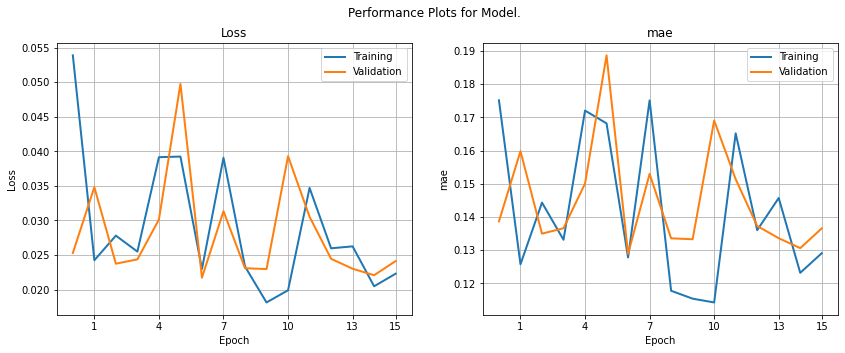

In [3]:
performance_plot(trained_model01a.history, metrics=['mae'])

In [55]:
# Inverse Transform of MinMaxScaler expects
# a shape (1, 17), we are going to do that
b = np.zeros((1, 17))
# We set the mean scaled IAQ of the last epoch 
# on the 5th column
b[0,4] = trained_model01a.history["val_mae"][-1]
## 
c = scaler_f.inverse_transform(b)
display(Markdown(f"* Mean Absolute Error in Real Scale of the last Epoch: \
**{c[0, 4]:.4f} IAQ points**."))

* Mean Absolute Error in Real Scale of the last Epoch: **67.6897 IAQ points**.